绘制IPTW的Table1。

包括加权前和加权后的Table1.

# 载入R包和数据

In [1]:
library(tableone)  # 制作基线表
library(survey)  # 提取加权结果
library(reshape2)  # 画SMD

Loading required package: grid

Loading required package: Matrix

Loading required package: survival


Attaching package: 'survey'


The following object is masked from 'package:graphics':

    dotchart




In [2]:
aa <- read.csv('../data/R15.csv', header = T, row.names = NULL, stringsAsFactors = F)

In [4]:
head(aa)

,status,time,rt,age,er,pr,her2,surg,che,g,t
,<int>,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,72,No,57,1,1,1,1,2,3,1
2,1,77,Yes,60,2,2,1,2,1,1,1
3,1,72,No,49,2,2,1,2,1,2,3
4,1,74,No,50,2,2,1,2,2,2,2
5,1,79,Yes,53,1,1,1,2,2,3,1
6,0,31,Yes,65,1,1,1,2,2,3,1


In [6]:
# 因子变量转换
for (i in names(aa)[c(1, 3, 5:11)]) {
  aa[, i] <- as.factor(aa[, i])
}

# 设定混杂因素

In [7]:
vars = c("age", "er", "pr", "her2", "surg", "che", "g", "t")

# 未加权的Table 1

In [9]:
#CreateTableOne()函数构建基线表，rt作为分类项
tab_Unmatched <- CreateTableOne(
  vars = vars,
  strata = "rt",
  data = aa,
  test = T
)

In [10]:
tab_Unmatched

                 Stratified by rt
                  No            Yes           p      test
  n                2180          2736                    
  age (mean (SD)) 51.21 (8.92)  50.99 (8.93)   0.392     
  er = 2 (%)       1707 (78.3)   2132 (77.9)   0.776     
  pr = 2 (%)       1482 (68.0)   1850 (67.6)   0.809     
  her2 = 2 (%)      456 (20.9)    523 (19.1)   0.125     
  surg = 2 (%)      530 (24.3)   1662 (60.7)  <0.001     
  che = 2 (%)      1554 (71.3)   2364 (86.4)  <0.001     
  g (%)                                        0.982     
     1              269 (12.3)    336 (12.3)             
     2              897 (41.1)   1120 (40.9)             
     3             1014 (46.5)   1280 (46.8)             
  t (%)                                       <0.001     
     1             1043 (47.8)   1215 (44.4)             
     2             1028 (47.2)   1210 (44.2)             
     3              109 ( 5.0)    311 (11.4)             

In [11]:
#展示标准化平均差，SMD
print(tab_Unmatched, showAllLevels=TRUE, smd = TRUE)

                 Stratified by rt
                  level No            Yes           p      test SMD   
  n                      2180          2736                           
  age (mean (SD))       51.21 (8.92)  50.99 (8.93)   0.392       0.025
  er (%)          1       473 (21.7)    604 (22.1)   0.776       0.009
                  2      1707 (78.3)   2132 (77.9)                    
  pr (%)          1       698 (32.0)    886 (32.4)   0.809       0.008
                  2      1482 (68.0)   1850 (67.6)                    
  her2 (%)        1      1724 (79.1)   2213 (80.9)   0.125       0.045
                  2       456 (20.9)    523 (19.1)                    
  surg (%)        1      1650 (75.7)   1074 (39.3)  <0.001       0.793
                  2       530 (24.3)   1662 (60.7)                    
  che (%)         1       626 (28.7)    372 (13.6)  <0.001       0.377
                  2      1554 (71.3)   2364 (86.4)                    
  g (%)           1       269 (12.3)    336

In [12]:
#查看有无SMD>10%
addmargins(table(ExtractSmd(tab_Unmatched) > 0.1))


FALSE  TRUE   Sum 
    5     3     8 

# 基于IPTW的Table 1

## 建模并计算PS

In [14]:
psModel <- glm(
  rt ~ age + er + pr + her2 + surg + che + g + t,
  family = binomial(link = "logit"),
  data = aa
)

#PS
aa$ps <- predict(psModel, type = "response")

## 逆处理概率加权

In [15]:
#1-逆概率，计算治疗组和对照组的逆概率
#根据1/PS和1/1-PS
aa$wt1 <- 1 / aa$ps
aa$wt0 <- 1 / (1 - aa$ps) 

#2-根据公式计算所有患者的权重
#假如患者为治疗组（Yes）用公式1加权，否则用公式2加权
aa$w <- ifelse(aa$rt == "Yes", aa$wt1, aa$wt0)

## ITPW后的数据做Table 1

In [23]:
#1-提取IPTW后的数据
dataIPTW <- svydesign(ids = ~1, data = aa,weights = ~w)

#2-再次构建Table-1
tab_IPTW <- svyCreateTableOne(
  vars = vars,
  strata = "rt",
  data = dataIPTW,
  test = T
)

#标准化差结果
print(tab_IPTW, showAllLevels = TRUE, smd = TRUE)

#查看是否有SMD>10%的混杂因素
addmargins(table(ExtractSmd(tab_IPTW) > 0.1))

                 Stratified by rt
                  level No              Yes             p      test SMD   
  n                     5082.19         4829.82                           
  age (mean (SD))         50.85 (8.99)    50.99 (9.10)   0.673       0.015
  er (%)          1      1166.1 (22.9)   1092.4 (22.6)   0.825       0.008
                  2      3916.1 (77.1)   3737.5 (77.4)                    
  pr (%)          1      1687.2 (33.2)   1594.5 (33.0)   0.911       0.004
                  2      3395.0 (66.8)   3235.4 (67.0)                    
  her2 (%)        1      4057.4 (79.8)   3856.2 (79.8)   0.997      <0.001
                  2      1024.8 (20.2)    973.7 (20.2)                    
  surg (%)        1      2683.9 (52.8)   2619.3 (54.2)   0.410       0.029
                  2      2398.3 (47.2)   2210.5 (45.8)                    
  che (%)         1       983.0 (19.3)    893.7 (18.5)   0.519       0.021
                  2      4099.2 (80.7)   3936.1 (81.5)            


FALSE   Sum 
    8     8 

In [26]:
# 查看加权后的数据框
head(dataIPTW)

Independent Sampling design (with replacement)
svydesign(ids = ~1, data = aa, weights = ~w)

# 标准化平均差SMD可视化

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."


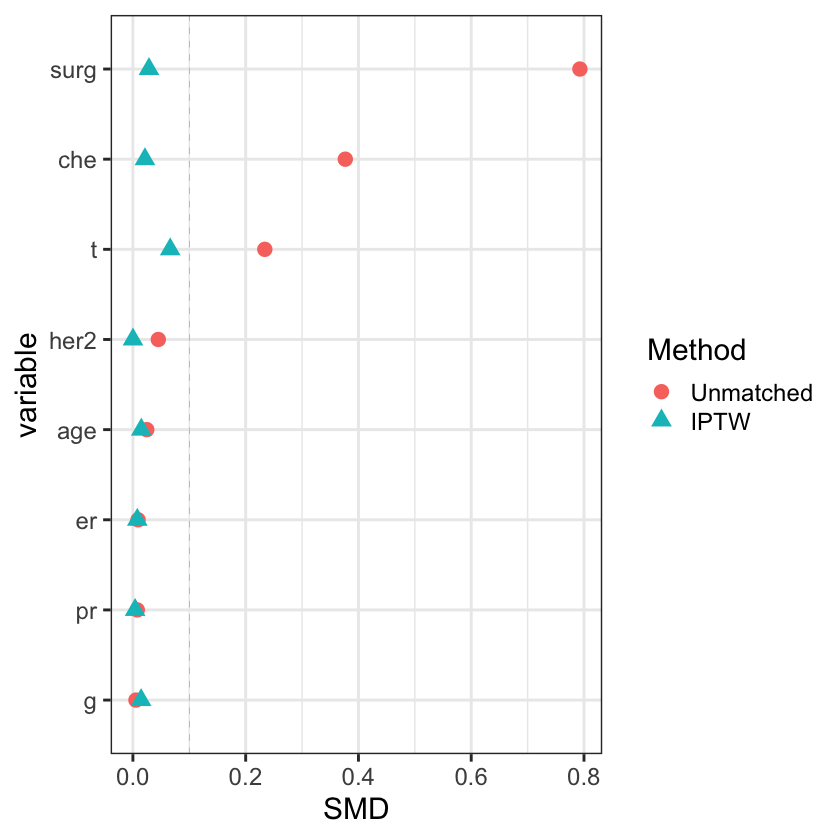

In [ ]:
library(ggplot2)

#提取作图数据
dataPlot <- data.frame(
  variable = rownames(ExtractSmd(tab_Unmatched)),
  Unmatched = as.numeric(ExtractSmd(tab_Unmatched)),
  IPTW = as.numeric(ExtractSmd(tab_IPTW))
)

#指定将要出现在图中的变量
dataPlotMelt<-melt(
  data = dataPlot,
  id.vars = c("variable"),
  variable.name = "Method",
  value.name= "SMD"
)

varNames <- as.character(dataPlot$variable)[order(dataPlot$Unmatched)]

dataPlotMelt$variable <- factor(dataPlotMelt$variable, levels = varNames)

#画图
ggplot(
  data = dataPlotMelt,
  mapping = aes(
    x = variable, y = SMD,
    group = Method,
    color = Method,
    shape = Method
  )
) +
  #geom_line() +
  geom_point(size = 4) +
  geom_hline(
    yintercept = 0.1,
    color = "red",
    lty = 2,
    size = 0.1
  ) +
  coord_flip() +
  theme_bw(base_size = 18)

# 两个Table 1合并输出

In [19]:
#1.提取两个结果
table1 <- cbind(
  print(tab_Unmatched, printToggle = F, showAllLevels = T),
  print(tab_IPTW, printToggle = F, showAllLevels = T)
)

# 插入一行分组
table1 <- rbind(Group=rep(c("Level", "RT", "No-RT", "P", "test"), 2), table1)

#更改列名
colnames(table1) <- c("Level", "Unmatched", NA, NA, NA, "Level", "IPTW", NA, NA, NA)

#打印或导出Excel
print(table1, quote = FALSE)

                Level Unmatched     <NA>          <NA>   <NA> Level
Group           Level RT            No-RT         P      test Level
n                      2180          2736                          
age (mean (SD))       51.21 (8.92)  50.99 (8.93)   0.392           
er (%)          1       473 (21.7)    604 (22.1)   0.776      1    
                2      1707 (78.3)   2132 (77.9)              2    
pr (%)          1       698 (32.0)    886 (32.4)   0.809      1    
                2      1482 (68.0)   1850 (67.6)              2    
her2 (%)        1      1724 (79.1)   2213 (80.9)   0.125      1    
                2       456 (20.9)    523 (19.1)              2    
surg (%)        1      1650 (75.7)   1074 (39.3)  <0.001      1    
                2       530 (24.3)   1662 (60.7)              2    
che (%)         1       626 (28.7)    372 (13.6)  <0.001      1    
                2      1554 (71.3)   2364 (86.4)              2    
g (%)           1       269 (12.3)    336 (12.3)